# Predict

In [15]:
import glob
from PIL import Image
from docopt import docopt
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from config import common_config as config
from dataset import Synth90kDataset, synth90k_collate_fn
from model import CRNN
from ctc_decoder import ctc_decode

### Parameter

In [2]:
images_dir = '../demo/*.jpg'

images_path = glob.glob(images_dir)
reload_checkpoint = '../checkpoints/crnn_synth90k.pt'
batch_size = 256
decode_method = 'beam_search'
beam_size = 10

img_height = 32
img_width = 100

num_class = len(Synth90kDataset.LABEL2CHAR) + 1

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda


### Data Loader

In [4]:
predict_dataset = Synth90kDataset(paths=images_path,
                                      img_height=img_height, img_width=img_width)

predict_loader = DataLoader(
    dataset=predict_dataset,
    batch_size=batch_size,
    shuffle=False)

### Load Model Object

In [5]:
crnn = CRNN(1, img_height, img_width, num_class,
                map_to_seq_hidden=config['map_to_seq_hidden'],
                rnn_hidden=config['rnn_hidden'],
                leaky_relu=config['leaky_relu'])
crnn.load_state_dict(torch.load(reload_checkpoint, map_location=device))
crnn.to(device)

<All keys matched successfully>

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (conv5): Conv2d(512, 512, 

In [6]:
pbar = tqdm(total=len(predict_loader), desc="Predict")
all_preds = []

Predict:   0%|                                                                                   | 0/1 [00:00<?, ?it/s]

### predict

In [7]:
with torch.no_grad():
        for data in predict_loader:
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images = data.to(device)

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            preds = ctc_decode(log_probs, method=decode_method, beam_size=beam_size,
                               label2char=Synth90kDataset.LABEL2CHAR)
            all_preds += preds

            pbar.update(1)
        pbar.close()

Predict: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]

True

Predict: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


### Display Predict Result

In [25]:
def show_result(paths, preds):
    print('\n===== result =====')
    for path, pred in zip(paths, preds):
        image = Image.open(path)
        _=plt.imshow(image)
        plt.show()
        text = ''.join(pred)
        print(f"Prediction: {text}")
#         print(f'{path} > {text}')


===== result =====


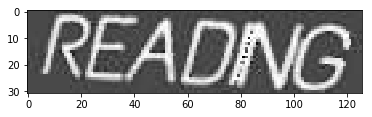

Prediction: reading


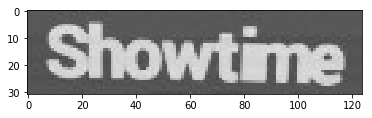

Prediction: showtime


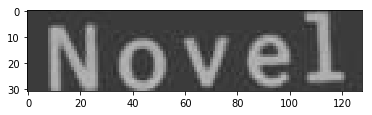

Prediction: novel


In [26]:
show_result(images_path, preds)